In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest

#### Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения.

In [2]:
orders = pd.read_csv('ab_orders.csv', parse_dates=['creation_time'])
products = pd.read_csv('ab_products.csv')
users = pd.read_csv('ab_users_data.csv', parse_dates=['time', 'date'])

In [3]:
# Сделаем табличку только с теми заказами, которые не были отменены.
users_not_canceled_orders = users\
    .sort_values('action')\
    .drop_duplicates(subset='order_id', keep='first')\
    .query('action=="create_order"')

In [4]:
orders.product_ids = orders.product_ids.str.strip('{}').str.split(', ')
orders = orders.explode('product_ids')
# Разобьем табличку с заказами так, чтобы на каждый заказ приходилась отдельная строчка

In [5]:
# Сделаем 2 единых датафрейма - со всеми заказами и только с теми, которые не были отменены.
df_not_canceled_orders = users_not_canceled_orders.merge(orders, on='order_id', how='inner')
df_not_canceled_orders = df_not_canceled_orders.rename(columns={'product_ids': 'product_id'})
df_not_canceled_orders.product_id = df_not_canceled_orders.product_id.astype('int')
df_not_canceled_orders = df_not_canceled_orders.merge(products, on='product_id', how='left').sort_values('order_id')
df_not_canceled_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
1354,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1355,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
1356,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
1357,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
8564,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0


In [6]:
df = users.merge(orders, on ='order_id', how='inner')
df = df.rename(columns={'product_ids': 'product_id'})
df.product_id = df.product_id.astype('int')
df = df.merge(products, on='product_id', how='left').sort_values('order_id')
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0


##### В качестве целевых метрик проверим: средний чек и долю неотмененных заказов

In [7]:
df_1 = df_not_canceled_orders.groupby(['order_id','group'], as_index=False)['price'].sum()

Взглянем на размер чека на графике. Визуально больших различий не заметно. Проверим это статистически. По графику видно, что распределение близко к нормальному, но, скорее всего, таковым не является. Тем не менее, так как отсутствуют значительные выбросы, а выборка большая, то можно применить t-тест

<Axes: xlabel='price', ylabel='Count'>

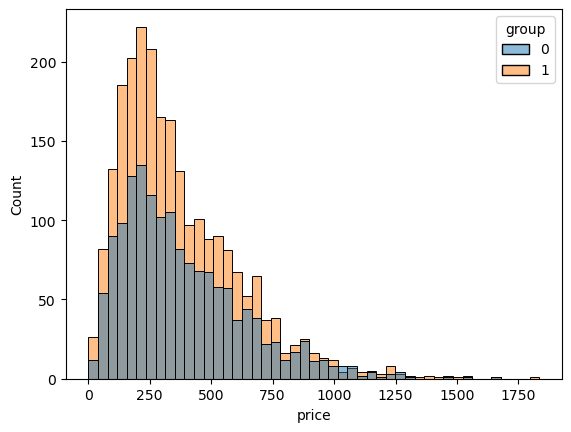

In [10]:
sns.histplot(data = df_1, x = df_1.price, hue='group')

Нулевая гипотеза: средние чеки в тестовой и контрольной группе не различаются статистически значимо.
Для начала проверим гомогенность дисперсий для проверки применимости t-теста:

In [8]:
ss.levene(df_1.query('group==0').price, df_1.query('group==1').price)

LeveneResult(statistic=1.011786232132759, pvalue=0.31453758452176295)

И воспользуемся t-тестом:

In [9]:
ss.ttest_ind(df_1.query('group==0').price, df_1.query('group==1').price)

Ttest_indResult(statistic=1.6334875192269402, pvalue=0.10244707728234669)

По результатам t-теста нет достаточных оснований отвергнуть нулевую гипотезу и заявлять о наличии разницы в размере среднего чека между тестовой и контрольной группами. 


---
Теперь проверим вторую метрику - <b>долю неотмененных заказов.</b> <br>
Нулевая гипотеза - доля неотменнных заказов статистически значимо не различается в обоих группах

In [22]:
print('Общая доля отмененных заказов составляет', (4337 - 3909 )/4307)

Общая доля отмененных заказов составляет 0.09937311353610402


Взглянем на график, на нем визуально не видно больших отличий в доле отмененных заказов:

<Axes: xlabel='group', ylabel='count'>

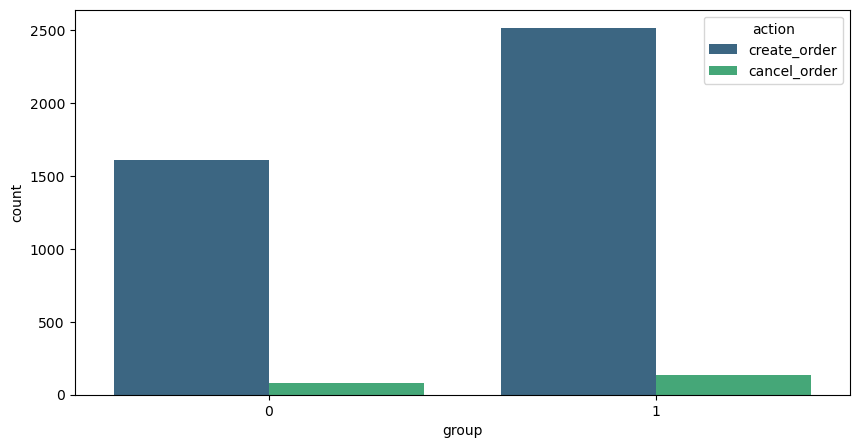

In [23]:
#На графике значимых отличий не видно. Ниже проверим статистически
plt.figure(figsize=(10,5))
sns.countplot(data = users, x = 'group', hue = 'action', palette = 'viridis')

In [22]:
group0_total = users.query('group==0').order_id.count()
group1_total = users.query('group==1').order_id.count()
group1_not_canceled = users_not_canceled_orders.query('group==1').order_id.count()
group0_not_canceled = users_not_canceled_orders.query('group==0').order_id.count()
print(group0_total, '- общее количество заказов в контрольной группе')
print(group1_total, '- общее количество заказов в тестовой группе')
print(group0_not_canceled, '- количество неотмененных заказов в контрольной группе')
print(group1_not_canceled, '- количество неотмененных заказов в тестовой группе')


1691 - общее количество заказов в контрольной группе
2646 - общее количество заказов в тестовой группе
1527 - количество неотмененных заказов в контрольной группе
2382 - количество неотмененных заказов в тестовой группе


Проведем z-тест:

In [24]:
stat, pval = proportions_ztest([group1_not_canceled, group0_not_canceled], [group1_total, group0_total])
pval
# тест не показал статистической значимости отличий

0.7638784339094905

Вторая нулевая гипотеза также не отвергается, тест не показал статистически значимого отличия в доле неотмененных (и отмененных, соответственно), заказов. 

In [25]:
stat

-0.3003916476320458

---
В качестве последней метрики проверим количество заказов на пользователя. <br>
Для начала взглянем на количество уникальных покупателей в каждой группе:

Text(0, 0.5, 'Количество уникальных пользователей')

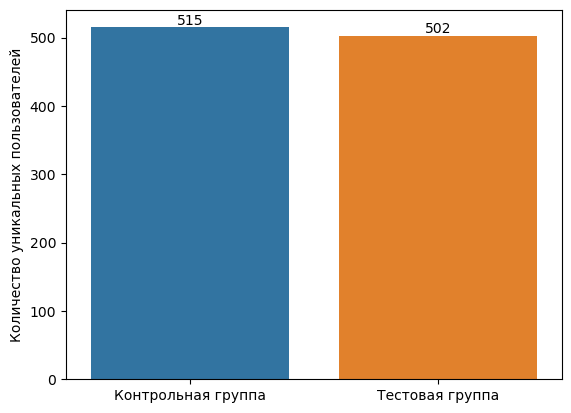

In [97]:
ax = sns.barplot(x=['Контрольная группа', 'Тестовая группа'], 
                 y=[df.query('group==0').user_id.nunique(), df.query('group==1').user_id.nunique()])
ax.bar_label(ax.containers[0], fontsize=10)
plt.ylabel('Количество уникальных пользователей')

И на среднее количество заказов на пользователя:

In [111]:
print(df.query('group==0').groupby('user_id')['order_id'].nunique().mean(), 
      '- среднее количество заказов в тестовой группе')
print(df.query('group==1').groupby('user_id')['order_id'].nunique().mean(), 
      '- среднее количество заказов в контрольной группе')

3.124271844660194 - среднее количество заказов в тестовой группе
5.00796812749004 - среднее количество заказов в контрольной группе


Text(0, 0.5, 'Количество пользователей')

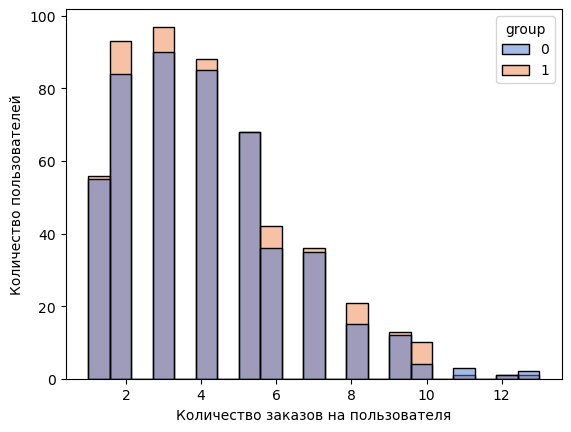

In [102]:
sns.histplot(data=df, x=df.groupby('user_id')['order_id'].nunique(), hue='group', palette='muted')
plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Количество пользователей')

Так как в наблюдении есть довольно большие выбросы, а выборки не очень большие, то воспользуемся бутстрэпом для сравнения средних:

In [108]:
print(ss.bootstrap((df.query('group==0').groupby('user_id')['order_id'].nunique(), ), np.mean))
print(ss.bootstrap((df.query('group==1').groupby('user_id')['order_id'].nunique(), ), np.mean))

BootstrapResult(confidence_interval=ConfidenceInterval(low=2.963106796116505, high=3.297087378640777), bootstrap_distribution=array([3.07184466, 3.19029126, 3.12621359, ..., 3.01747573, 2.9631068 ,
       3.29708738]), standard_error=0.08599167318279234)
BootstrapResult(confidence_interval=ConfidenceInterval(low=4.816733067729084, high=5.207171314741036), bootstrap_distribution=array([5.19123506, 4.99003984, 4.97410359, ..., 5.00398406, 5.07569721,
       4.98007968]), standard_error=0.09938804513733183)


По результатам теста, среднее количество заказов в тестовой группе значительно больше, чем в тестовой (доверительные интервалы среднего не пересекаются)

### Вывод по результатам исследования: между контрольной и тестовой группой нет статистически значимых различий в среднем чеке и количестве отмененных заказов, но при этом в тестовой группе значительно выше количество заказов на пользователя. Таким образом, общая выручка в тестовой группе выше. <br> 
### Целесообразно выкатить новую систему рекомендаций товаров на всех пользователей
